In [84]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [85]:
df = pd.read_csv('BodyFitnessPrediction.csv')
df

,date,step_count,mood,calories_burned,hours_of_sleep,bool_of_active,weight_kg
0,06-10-2017,5464,200,181,5,0,66
1,07-10-2017,6041,100,197,8,0,66
2,08-10-2017,25,100,0,5,0,66
3,09-10-2017,5461,100,174,4,0,66
4,10-10-2017,6915,200,223,5,500,66
...,...,...,...,...,...,...,...
667,04-08-2019,133,100,4,3,0,64
668,05-08-2019,153,300,4,8,0,64
669,06-08-2019,500,200,7,5,500,64
670,07-08-2019,2127,200,87,5,0,64


Data Analysis

In [86]:
del df['date'] 

In [87]:
display(df)

,step_count,mood,calories_burned,hours_of_sleep,bool_of_active,weight_kg
0,5464,200,181,5,0,66
1,6041,100,197,8,0,66
2,25,100,0,5,0,66
3,5461,100,174,4,0,66
4,6915,200,223,5,500,66
...,...,...,...,...,...,...
667,133,100,4,3,0,64
668,153,300,4,8,0,64
669,500,200,7,5,500,64
670,2127,200,87,5,0,64


**Scalling the Data**

Using SMOTE(Synthetic Minority Oversampling Technique) to generates synthetic data for the minority class.

In [88]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

X = df.drop(["bool_of_active"],axis=1)
y = df['bool_of_active']

In [89]:
X_smote, y_smote = smote.fit_resample(X, y)

In [90]:
y_smote.value_counts()

0      364
500    364
Name: bool_of_active, dtype: int64

In [91]:
#New dataset after over-sampeling the minority class
df_new = X_smote.assign(status = y_smote)
df_new

,step_count,mood,calories_burned,hours_of_sleep,weight_kg,status
0,5464,200,181,5,66,0
1,6041,100,197,8,66,0
2,25,100,0,5,66,0
3,5461,100,174,4,66,0
4,6915,200,223,5,66,500
...,...,...,...,...,...,...
723,4921,249,158,4,64,500
724,4921,228,158,5,64,500
725,4006,300,140,8,64,500
726,616,300,23,4,64,500


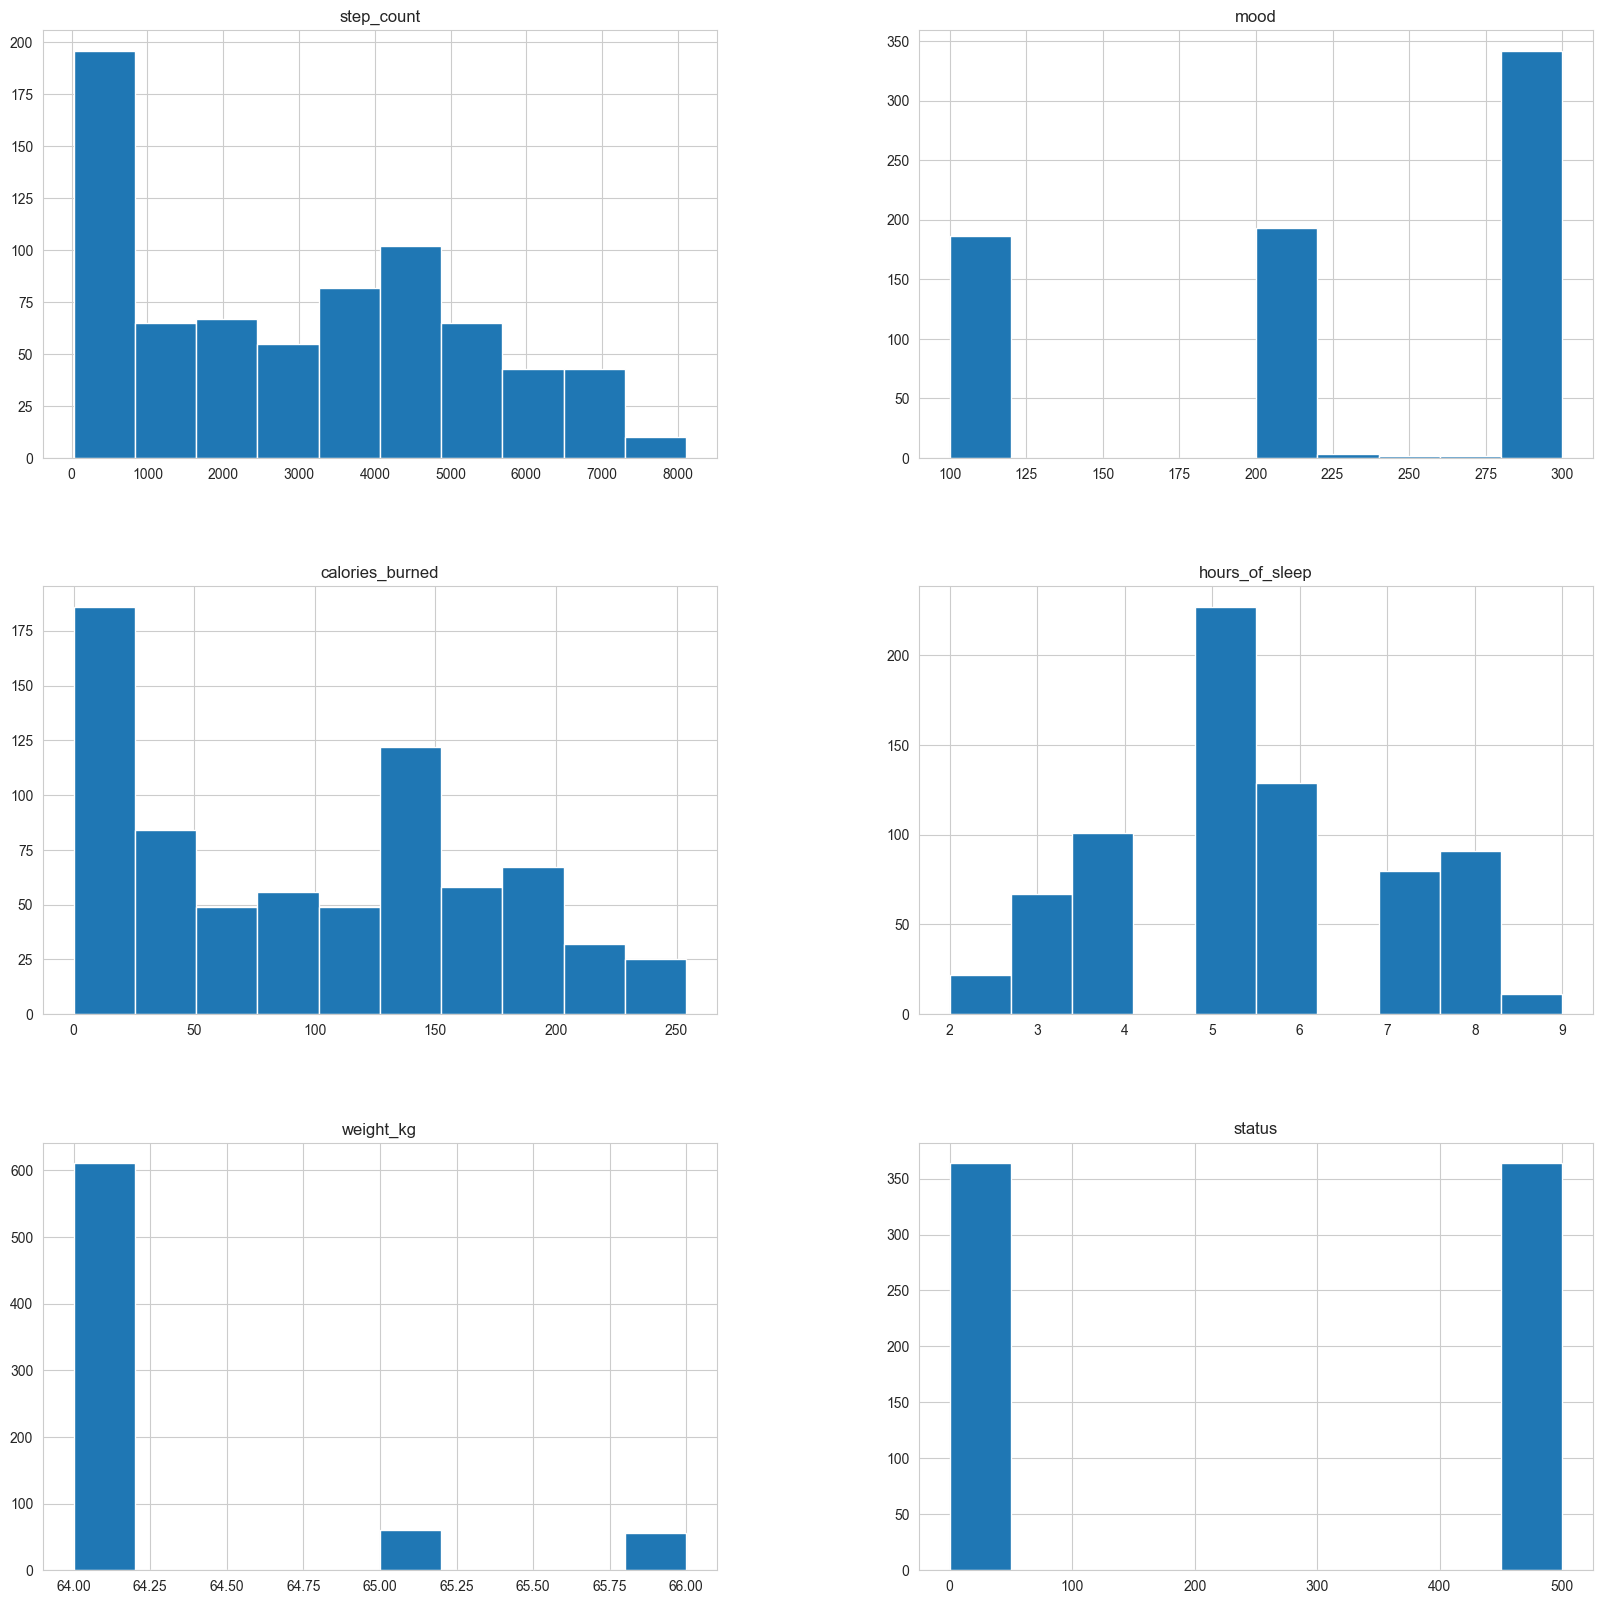

In [92]:
# Evaluating distributions of the features 
hist_plot = df_new.hist(figsize = (20,20))

Feature Selectiion using correlation

In [93]:
# Examining correlation matrix using heatmap
df_corr = df_new.corr()
fig = px.imshow(df_corr,
                x = df_corr.columns,
                y = df_corr.columns,
                title = 'Correlation Matrix',
                labels = dict(x="Features", y="Features", color="corelation"),
                height = 2000,
                width = 2000,
                text_auto=True)

In [94]:
corr_matrix = df_new.corr()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

df_new.drop(to_drop, axis=1, inplace=True)


In [95]:
df_new.columns

Index(['step_count', 'mood', 'hours_of_sleep', 'weight_kg', 'status'], dtype='object')

In [96]:
df_new

,step_count,mood,hours_of_sleep,weight_kg,status
0,5464,200,5,66,0
1,6041,100,8,66,0
2,25,100,5,66,0
3,5461,100,4,66,0
4,6915,200,5,66,500
...,...,...,...,...,...
723,4921,249,4,64,500
724,4921,228,5,64,500
725,4006,300,8,64,500
726,616,300,4,64,500


In [97]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   step_count      728 non-null    int64
 1   mood            728 non-null    int64
 2   hours_of_sleep  728 non-null    int64
 3   weight_kg       728 non-null    int64
 4   status          728 non-null    int64
dtypes: int64(5)
memory usage: 28.6 KB


**Data Analysis**

In [98]:
df.shape

(672, 6)

In [99]:
df.columns

Index(['step_count', 'mood', 'calories_burned', 'hours_of_sleep',
       'bool_of_active', 'weight_kg'],
      dtype='object')

In [100]:
df.count()

step_count         672
mood               672
calories_burned    672
hours_of_sleep     672
bool_of_active     672
weight_kg          672
dtype: int64

In [101]:
df.step_count.value_counts()

6041    9
500     8
1163    7
2203    7
6314    7
       ..
708     1
560     1
234     1
5298    1
170     1
Name: step_count, Length: 319, dtype: int64

In [102]:
df.isna().any()

step_count         False
mood               False
calories_burned    False
hours_of_sleep     False
bool_of_active     False
weight_kg          False
dtype: bool

In [103]:
df['mood'].unique()

array([200, 100, 300], dtype=int64)

In [104]:
df['bool_of_active'].unique()


array([  0, 500], dtype=int64)

In [105]:
df['weight_kg'].unique()


array([66, 65, 64], dtype=int64)

In [106]:
df['hours_of_sleep'].unique()


array([5, 8, 4, 6, 7, 3, 2, 9], dtype=int64)

In [107]:
df.describe()

,step_count,mood,calories_burned,hours_of_sleep,bool_of_active,weight_kg
count,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000
mean,2951.037202,219.196429,96.486607,5.391369,229.166667,64.254464
std,2151.796733,83.535566,71.914876,1.624179,249.316004,0.597419
min,25.000000,100.000000,0.000000,2.000000,0.000000,64.000000
25%,753.000000,100.000000,24.000000,4.000000,0.000000,64.000000
50%,3049.500000,200.000000,99.000000,5.000000,0.000000,64.000000
75%,4561.750000,300.000000,150.250000,6.000000,500.000000,64.000000
max,8109.000000,300.000000,254.000000,9.000000,500.000000,66.000000


In [108]:
cor=df.corr()

In [109]:
df.corr()

,step_count,mood,calories_burned,hours_of_sleep,bool_of_active,weight_kg
step_count,1.000000,0.278707,0.988923,0.155378,0.200615,0.103676
mood,0.278707,1.000000,0.268624,0.210364,0.407431,-0.402624
calories_burned,0.988923,0.268624,1.000000,0.152027,0.188440,0.107179
hours_of_sleep,0.155378,0.210364,0.152027,1.000000,0.142538,0.150635
bool_of_active,0.200615,0.407431,0.188440,0.142538,1.000000,-0.292042
weight_kg,0.103676,-0.402624,0.107179,0.150635,-0.292042,1.000000


**Data Visualization :**

Univariate Analysis

Text(0.5, 1.0, 'ANALYSIS OF MOOD')

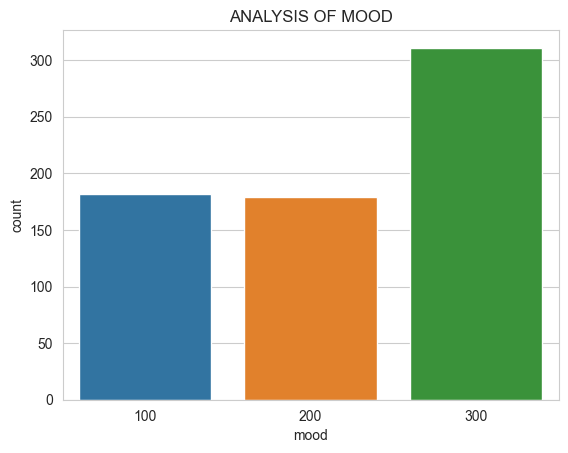

In [110]:
sns.countplot(x=df['mood'])
plt.title("ANALYSIS OF MOOD")

Text(0.5, 1.0, 'ANALYSIS OF BOOL OF ACTIVE')

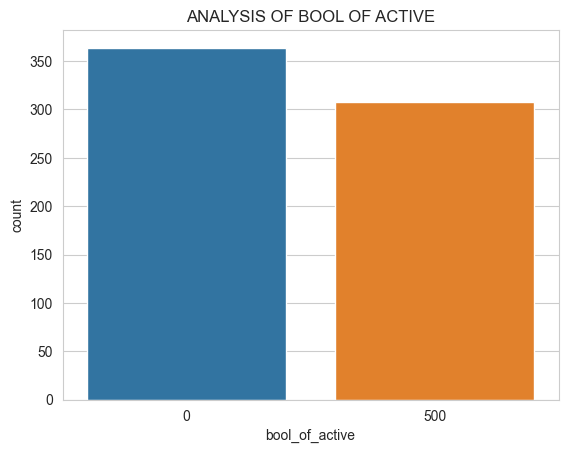

In [111]:
sns.countplot(x=df['bool_of_active'])
plt.title("ANALYSIS OF BOOL OF ACTIVE")

Text(0.5, 1.0, 'ANALYSIS OF WEIGHT')

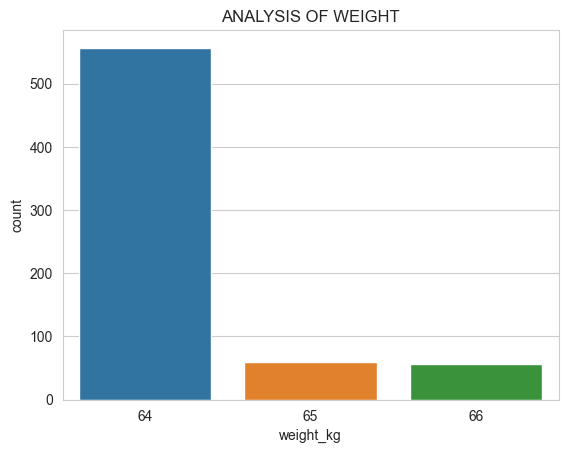

In [112]:
sns.countplot(x=df['weight_kg'])
plt.title("ANALYSIS OF WEIGHT")

Text(0.5, 1.0, 'ANALYSIS OF STATUS')

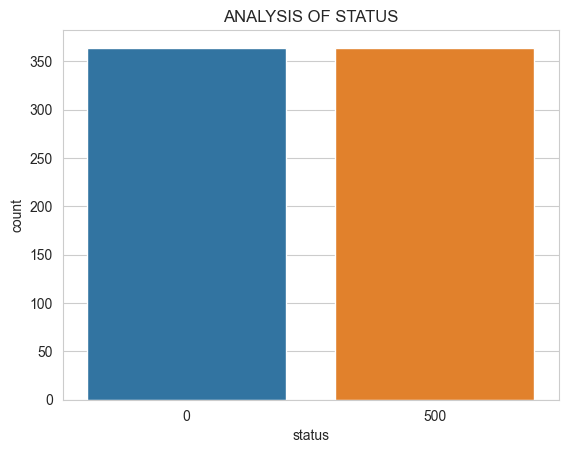

In [113]:
sns.countplot(x=df_new['status'])
plt.title("ANALYSIS OF STATUS")

Text(0.5, 1.0, 'ANALYSIS OF SLEEP')

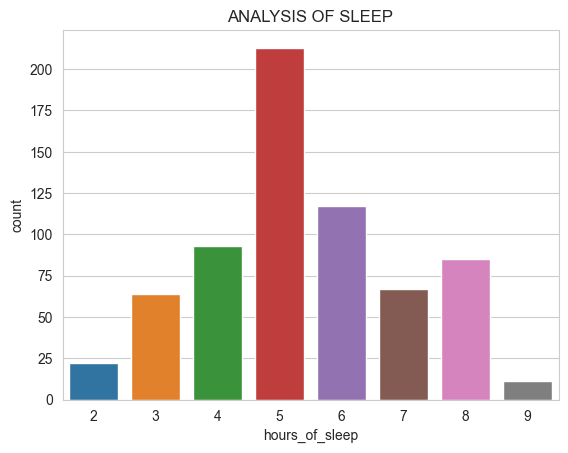

In [114]:
sns.countplot(x=df['hours_of_sleep'])
plt.title("ANALYSIS OF SLEEP")

<AxesSubplot: >

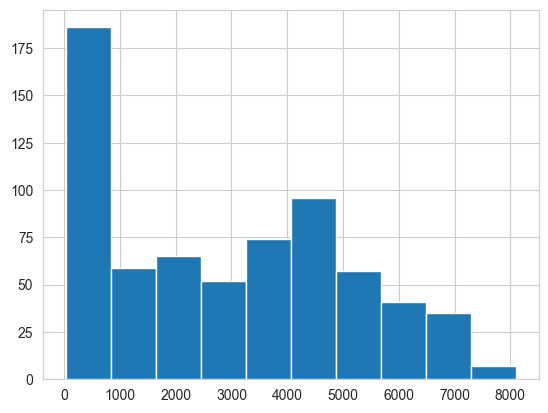

In [115]:
df['step_count'].hist() 

<AxesSubplot: xlabel='step_count', ylabel='Density'>

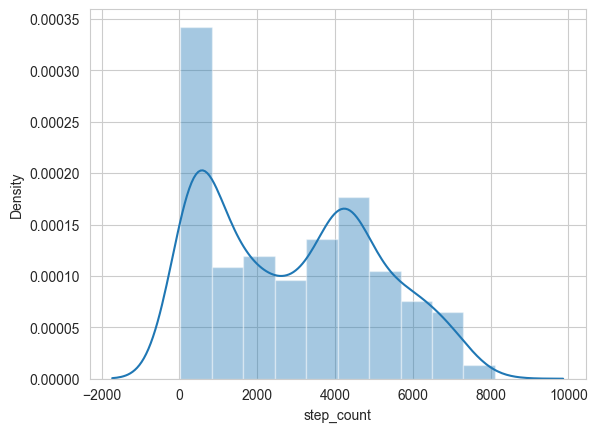

In [116]:
sns.distplot(df['step_count'])

<AxesSubplot: >

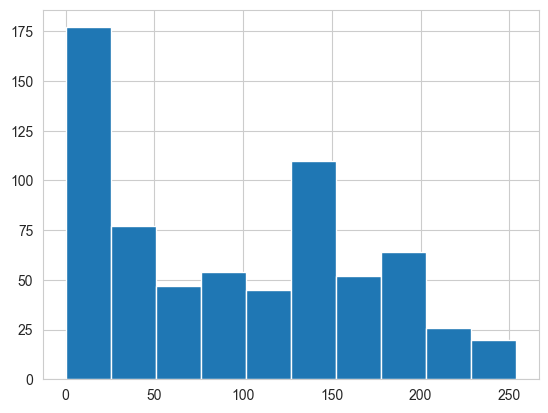

In [117]:
df['calories_burned'].hist() 

<AxesSubplot: xlabel='calories_burned', ylabel='Density'>

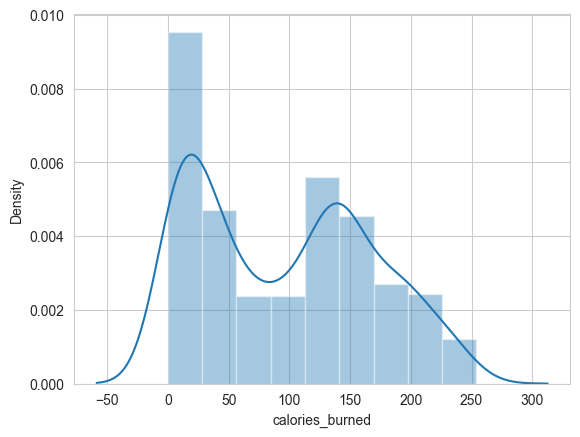

In [118]:
sns.distplot(df['calories_burned'])

<AxesSubplot: >

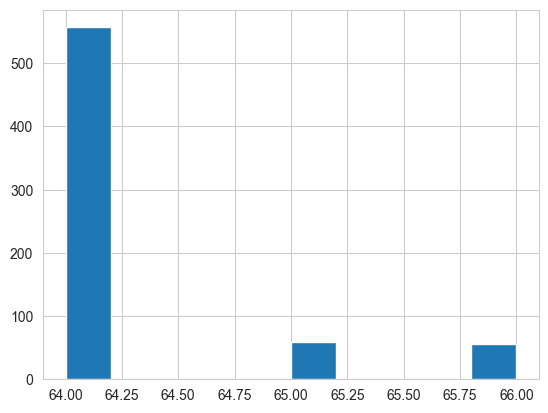

In [119]:
df['weight_kg'].hist() 

In [120]:
df['weight_kg'].value_counts()

64    557
65     59
66     56
Name: weight_kg, dtype: int64

<AxesSubplot: >

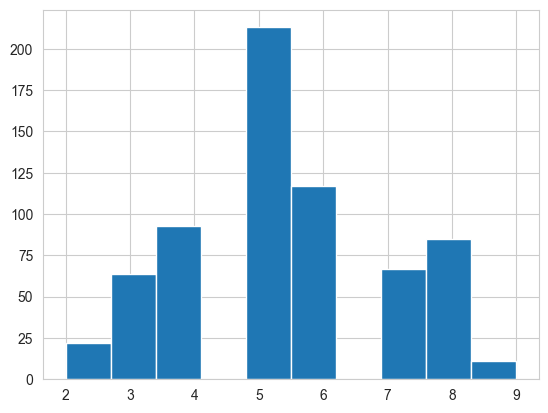

In [121]:
df['hours_of_sleep'].hist()

<AxesSubplot: >

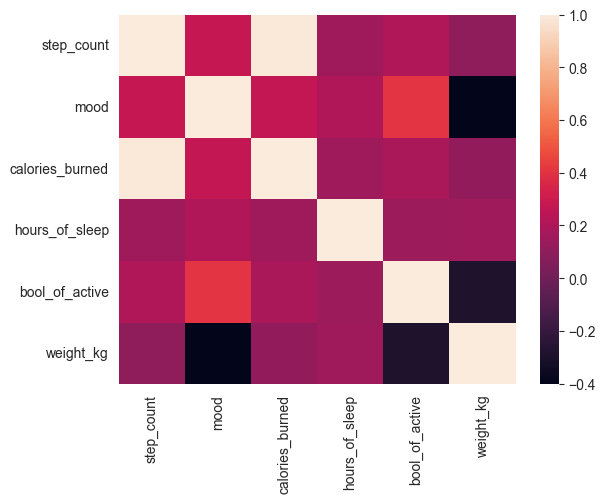

In [122]:
corr=df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns)  #Heatmap

<AxesSubplot: >

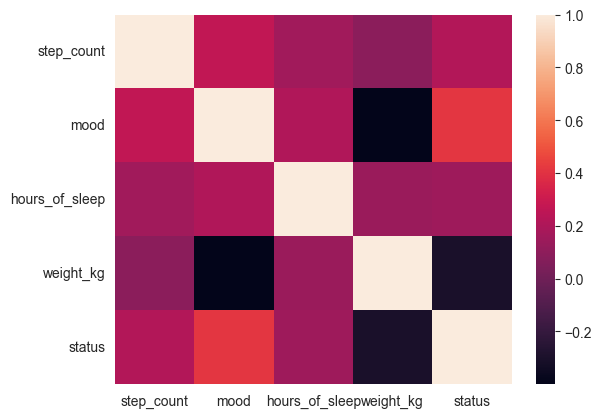

In [123]:
corr=df_new.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns)  #Heatmap

<AxesSubplot: xlabel='step_count', ylabel='calories_burned'>

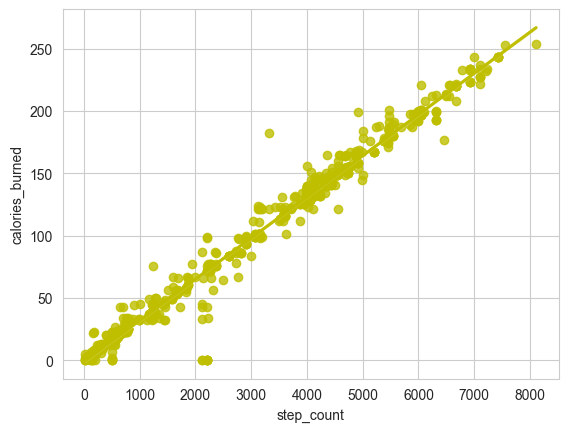

In [124]:
sns.regplot(x='step_count', y='calories_burned', data=df,color='y') 

<AxesSubplot: xlabel='weight_kg', ylabel='mood'>

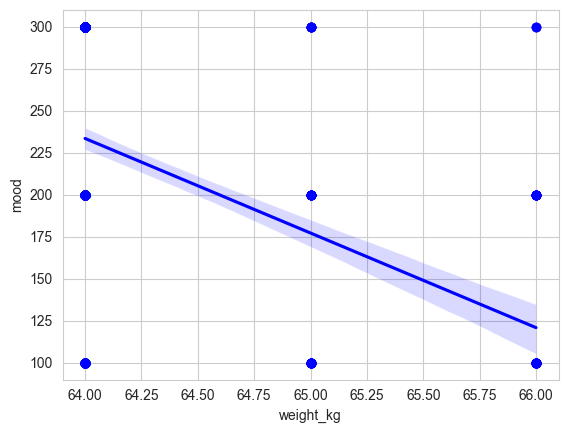

In [125]:
sns.regplot(x='weight_kg', y='mood', data=df,color='b') 

<AxesSubplot: xlabel='mood', ylabel='bool_of_active'>

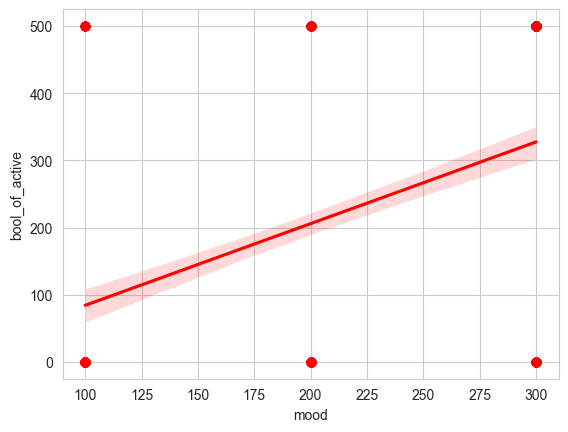

In [126]:
sns.regplot(x='mood', y='bool_of_active', data=df,color='r')

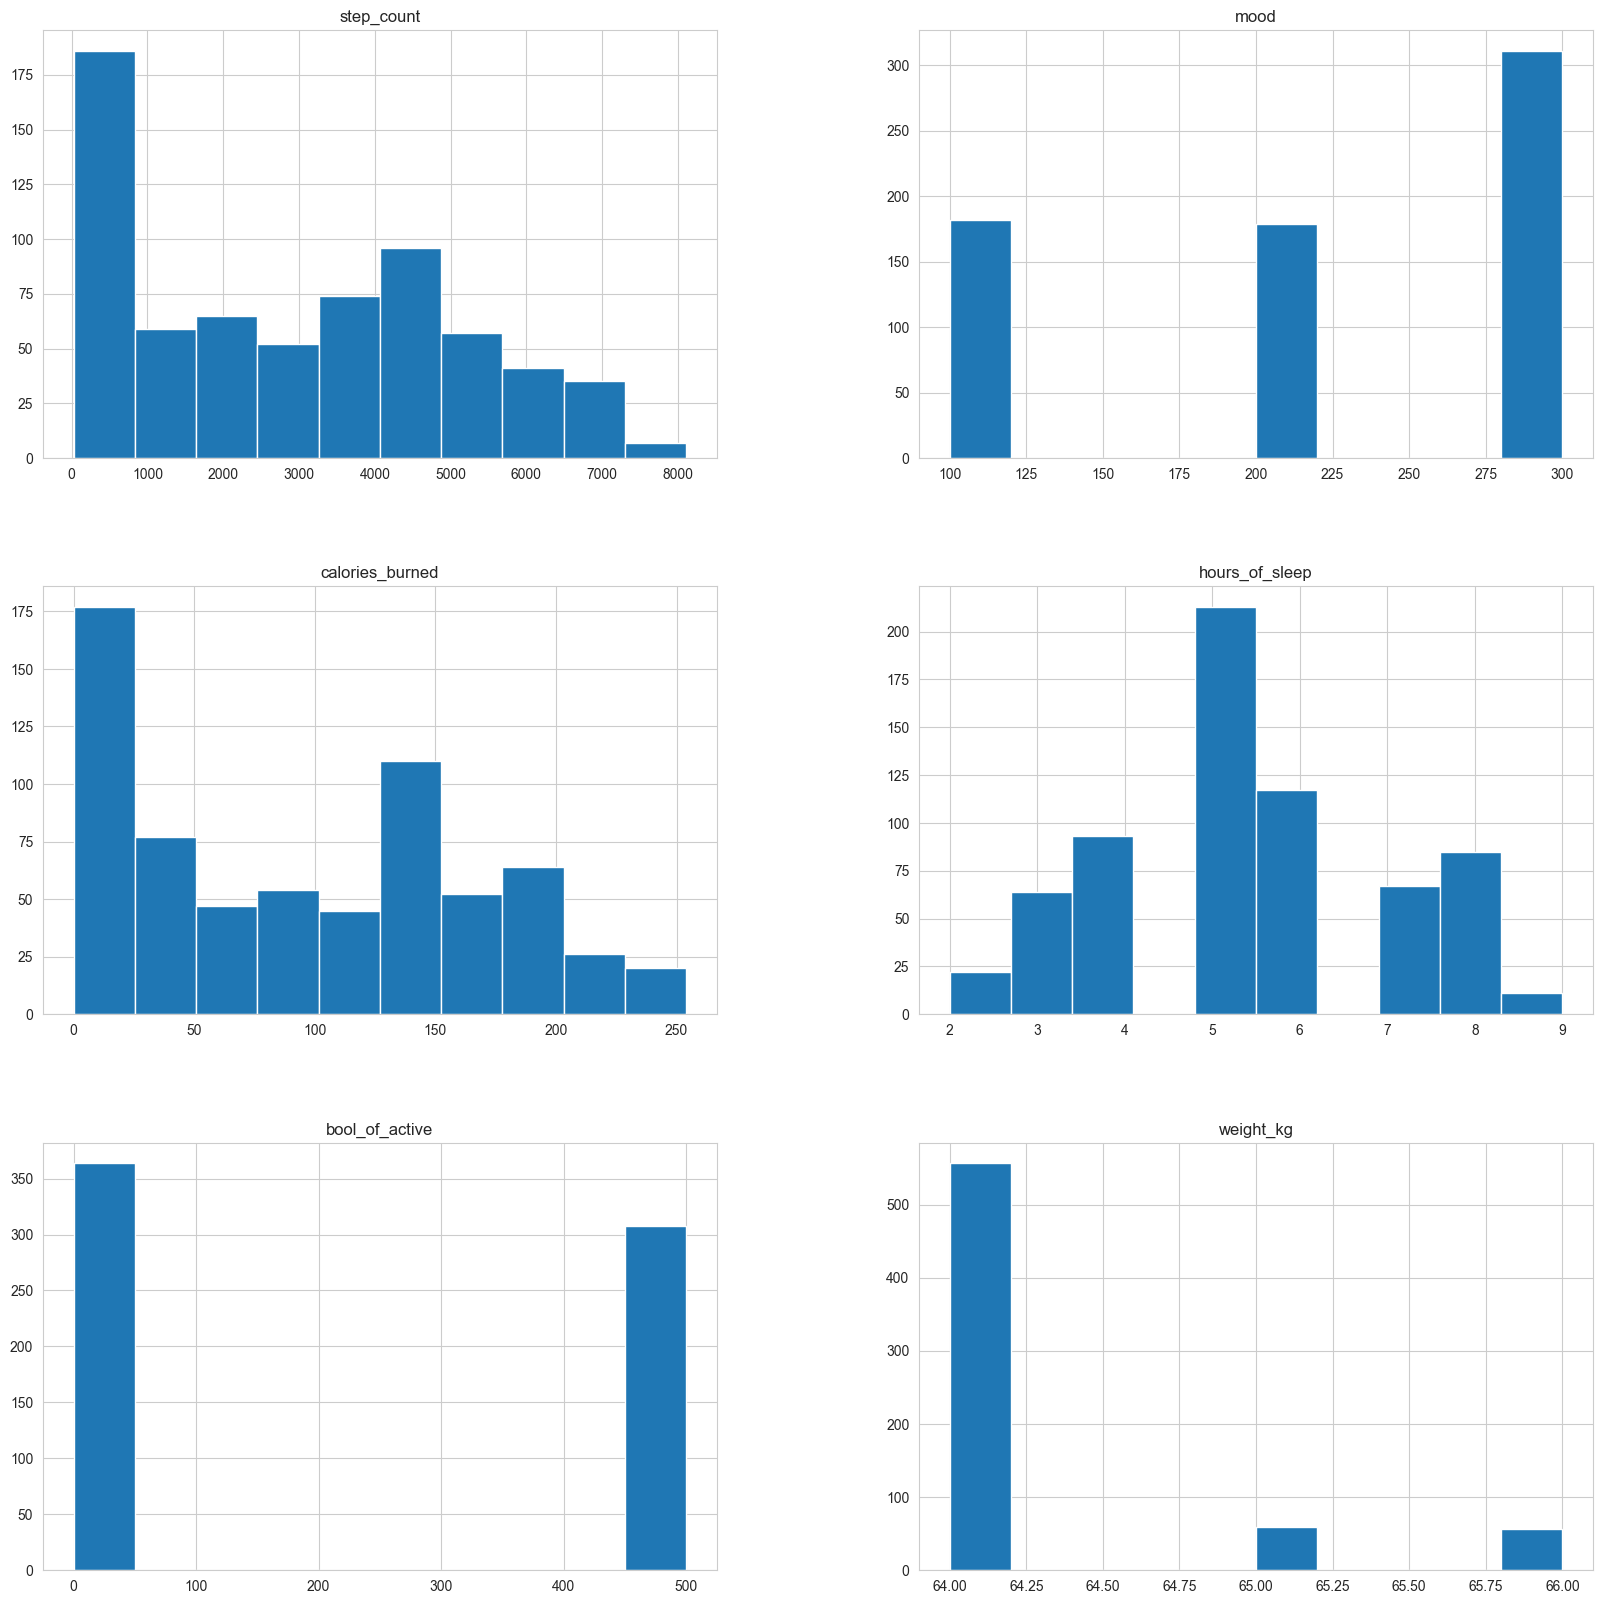

In [127]:
hist_plot = df.hist(figsize = (20,20))

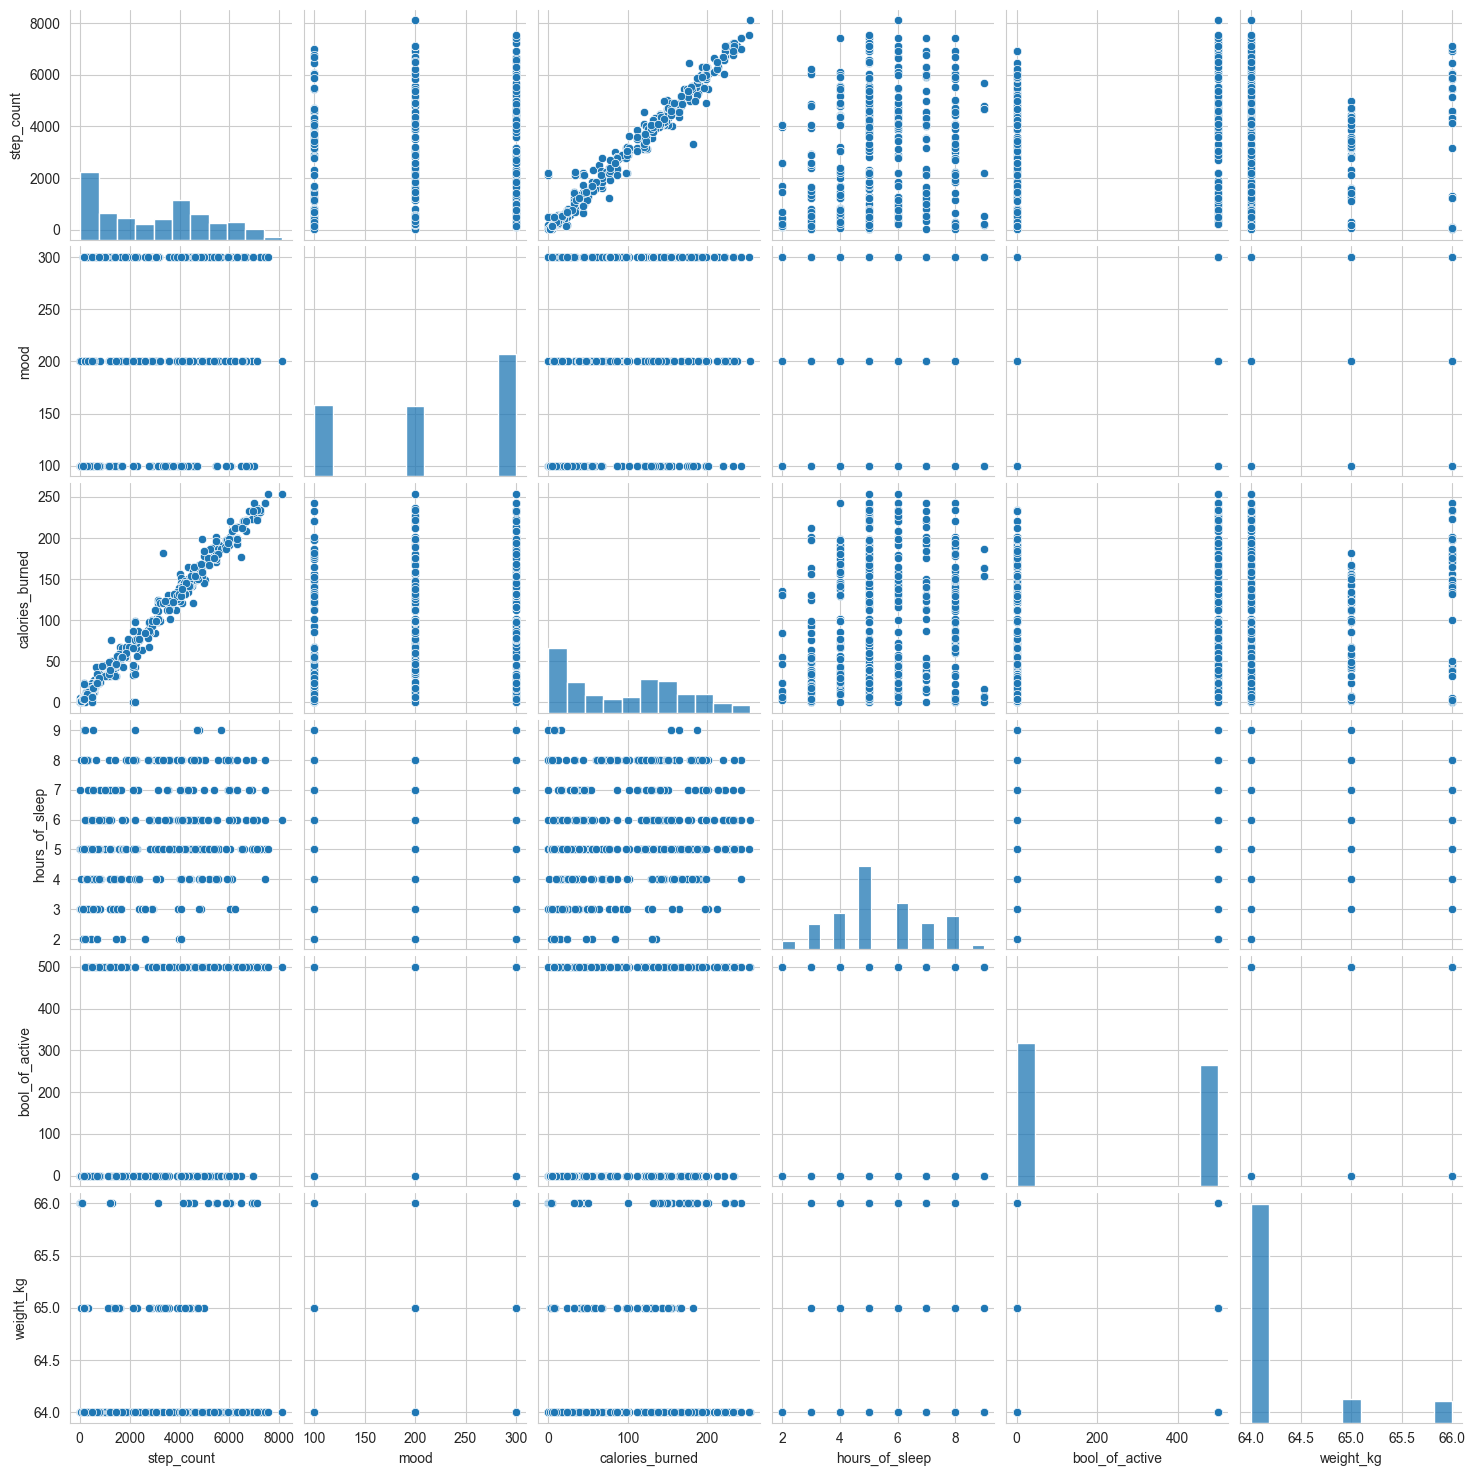

In [128]:
sns.set_style("whitegrid")
sns.pairplot(df)

**Bivariate Analysis**

Step count & Mood

In [129]:
df.step_count.groupby(df.mood).describe()
#Average_descriptive statistics of step count by mood category (100 = sad, 200 = neutral and 300 = happy)

,count,mean,std,min,25%,50%,75%,max
mood,,,,,,,,
100,182.0,1990.126374,1970.094038,25.0,299.0,1230.0,3586.0,6999.0
200,179.0,3027.094972,2140.411734,25.0,1163.0,2909.0,4390.5,8109.0
300,311.0,3469.594855,2076.114290,111.0,1425.0,4033.0,4880.0,7543.0


<Figure size 600x500 with 0 Axes>

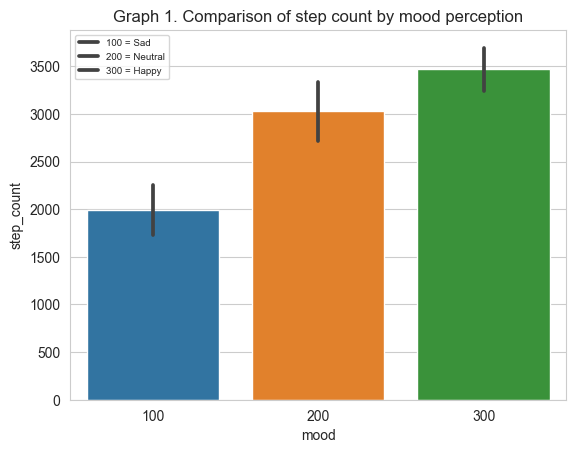

<Figure size 600x500 with 0 Axes>

In [130]:
sns.barplot(x = "mood", y="step_count", data = df)
plt.title('Graph 1. Comparison of step count by mood perception')
plt.legend(['100 = Sad', '200 = Neutral', '300 = Happy'], loc='upper left', prop={'size': 7})
plt.figure(figsize=(6,5))

Step count & Activeness

In [131]:
df.step_count.groupby(df.bool_of_active).describe()
#Average descriptive statistics_ of step count by Activeness (0 = inactive and 500 = active)

,count,mean,std,min,25%,50%,75%,max
bool_of_active,,,,,,,,
0,364.0,2554.241758,1996.747594,25.0,546.0,2255.0,4340.0,6930.0
500,308.0,3419.977273,2235.748340,221.0,1163.0,3608.0,5000.5,8109.0


<Figure size 600x500 with 0 Axes>

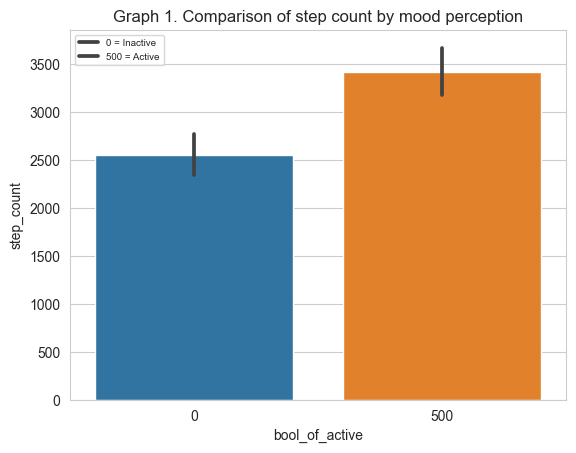

<Figure size 600x500 with 0 Axes>

In [132]:
sns.barplot(x = "bool_of_active", y="step_count", data = df)
plt.title('Graph 1. Comparison of step count by mood perception')
plt.legend(['0 = Inactive', '500 = Active'], loc='upper left', prop={'size': 7})
plt.figure(figsize=(6,5))

Calories Burned & Mood

In [133]:
df.calories_burned.groupby(df.mood).describe()
#Average descriptive statistics of CALORIES SPENT by mood category (100 = sad, 200 = neutral and 300 = happy)


,count,mean,std,min,25%,50%,75%,max
mood,,,,,,,,
100,182.0,66.252747,65.101042,0.0,11.0,38.5,122.75,243.0
200,179.0,97.474860,72.416424,0.0,33.5,98.0,147.50,254.0
300,311.0,113.610932,69.837275,0.0,43.5,132.0,165.00,253.0


<Figure size 600x500 with 0 Axes>

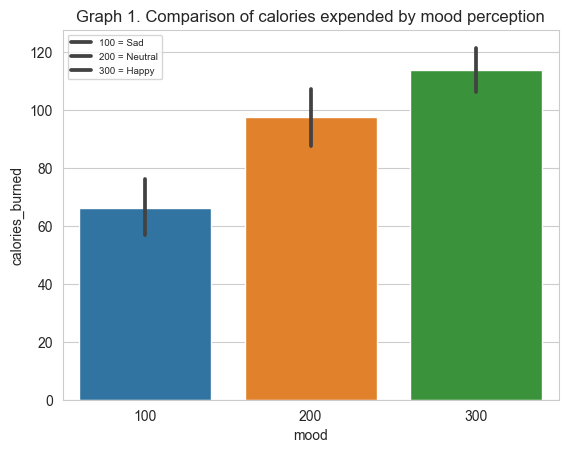

<Figure size 600x500 with 0 Axes>

In [134]:
sns.barplot(x = "mood", y="calories_burned", data = df)
plt.title('Graph 1. Comparison of calories expended by mood perception')
plt.legend(['100 = Sad', '200 = Neutral', '300 = Happy'], loc='upper left', prop={'size': 7})
plt.figure(figsize=(6,5))

Calories Burned & Activeness

In [135]:
df.calories_burned.groupby(df.bool_of_active).describe()
#Average descriptive statistics_ of CALORIES SPENT by Activeness (0 = inactive and 500 = active)


,count,mean,std,min,25%,50%,75%,max
bool_of_active,,,,,,,,
0,364.0,84.030220,66.986506,0.0,19.25,74.5,142.25,234.0
500,308.0,111.207792,74.810656,0.0,35.00,120.0,168.25,254.0


<Figure size 600x500 with 0 Axes>

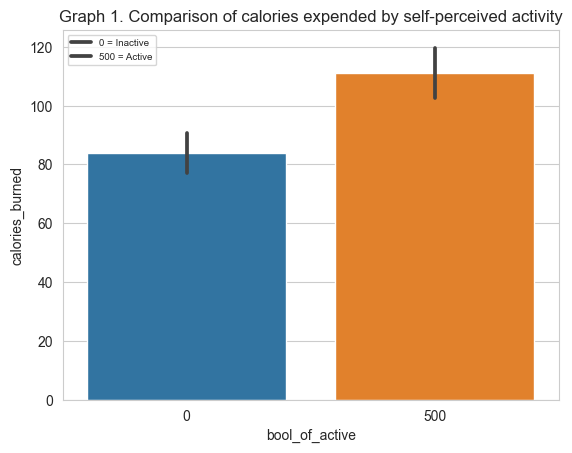

<Figure size 600x500 with 0 Axes>

In [136]:
sns.barplot(x = "bool_of_active", y="calories_burned", data = df)
plt.title('Graph 1. Comparison of calories expended by self-perceived activity')
plt.legend(['0 = Inactive', '500 = Active'], loc='upper left', prop={'size': 7})
plt.figure(figsize=(6,5))

Sleeping Hours & Mood

In [137]:
df.hours_of_sleep.groupby(df.mood).describe()

,count,mean,std,min,25%,50%,75%,max
mood,,,,,,,,
100,182.0,5.093407,1.801491,2.0,4.0,5.0,6.0,9.0
200,179.0,4.927374,1.365827,2.0,4.0,5.0,6.0,8.0
300,311.0,5.832797,1.540115,2.0,5.0,6.0,7.0,9.0


<Figure size 600x500 with 0 Axes>

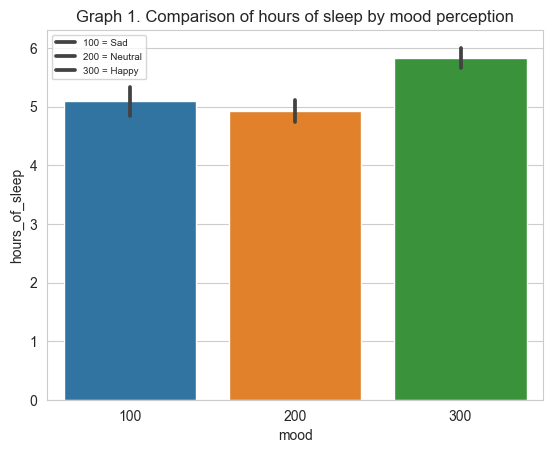

<Figure size 600x500 with 0 Axes>

In [138]:
sns.barplot(x = "mood", y="hours_of_sleep", data = df)
plt.title('Graph 1. Comparison of hours of sleep by mood perception')
plt.legend(['100 = Sad', '200 = Neutral', '300 = Happy'], loc='upper left', prop={'size': 7})
plt.figure(figsize=(6,5))

Sleeping Hours & Activeness

In [139]:
df.hours_of_sleep.groupby(df.bool_of_active).describe()

,count,mean,std,min,25%,50%,75%,max
bool_of_active,,,,,,,,
0,364.0,5.178571,1.706730,2.0,4.0,5.0,6.0,9.0
500,308.0,5.642857,1.484682,2.0,5.0,5.0,7.0,9.0


<Figure size 600x500 with 0 Axes>

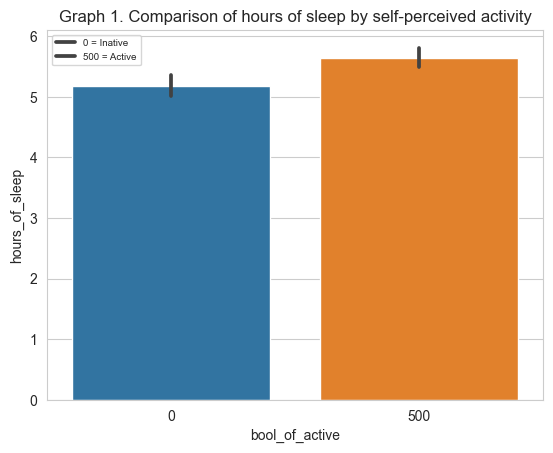

<Figure size 600x500 with 0 Axes>

In [140]:
sns.barplot(x = "bool_of_active", y="hours_of_sleep", data = df)
plt.title('Graph 1. Comparison of hours of sleep by self-perceived activity')
plt.legend(['0 = Inative', '500 = Active'], loc='upper left', prop={'size': 7})
plt.figure(figsize=(6,5))

Mood & Activeness

In [141]:
pd.crosstab([df. bool_of_active], [df.mood], normalize='index', margins=True)*100

mood,100,200,300
bool_of_active,,,
0,42.582418,26.923077,30.494505
500,8.766234,26.298701,64.935065
All,27.083333,26.636905,46.279762


<Figure size 600x500 with 0 Axes>

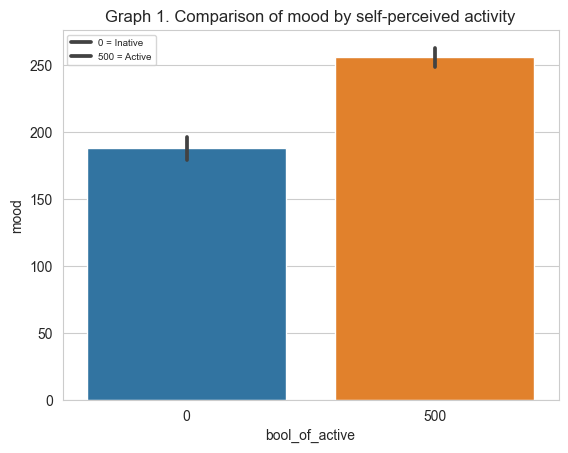

<Figure size 600x500 with 0 Axes>

In [142]:
sns.barplot(x = "bool_of_active", y="mood", data = df)
plt.title('Graph 1. Comparison of mood by self-perceived activity')
plt.legend(['0 = Inative', '500 = Active'], loc='upper left', prop={'size': 7})
plt.figure(figsize=(6,5))

Mood & Weight

In [143]:
df.weight_kg.groupby(df.mood).describe()

,count,mean,std,min,25%,50%,75%,max
mood,,,,,,,,
100,182.0,64.637363,0.821217,64.0,64.0,64.0,65.0,66.0
200,179.0,64.229050,0.568899,64.0,64.0,64.0,64.0,66.0
300,311.0,64.045016,0.249966,64.0,64.0,64.0,64.0,66.0


<Figure size 600x500 with 0 Axes>

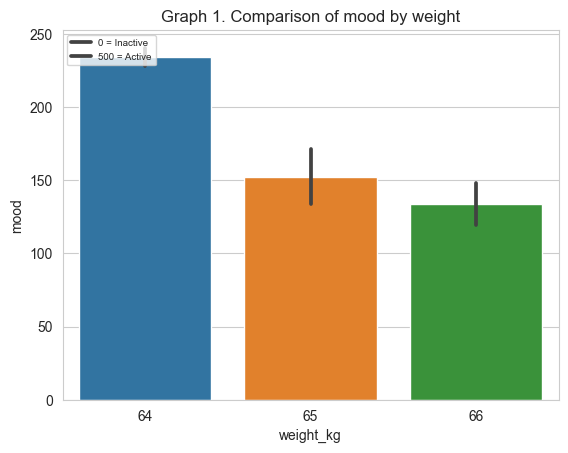

<Figure size 600x500 with 0 Axes>

In [144]:
sns.barplot(x = "weight_kg", y="mood", data = df)
plt.title('Graph 1. Comparison of mood by weight')
plt.legend(['0 = Inactive', '500 = Active'], loc='upper left', prop={'size': 7})
plt.figure(figsize=(6,5))

**Final Observation :
We want to predict whether a person is active or inactive which is a Binary classification problem based on hours slept, mood, daily step count, calories burned and weight.**

**Label Encoding**

1. "Mood" and "bool_of_active" are categorical variables but they are represented as
--> bool_of_active : Active - 500 and Inactive - 0
--> mood : 100 - sad, 200 - neutral and 300 - happy 
2. Encode mood values as
--> 100 - 0, 200 - 1 and 300 - 2 
3. Encode bool_of_active values as
--> 0 - 0 and 500 - 1

In [145]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['bool_of_active']=le.fit_transform(df['bool_of_active'])
df

,step_count,mood,calories_burned,hours_of_sleep,bool_of_active,weight_kg
0,5464,200,181,5,0,66
1,6041,100,197,8,0,66
2,25,100,0,5,0,66
3,5461,100,174,4,0,66
4,6915,200,223,5,1,66
...,...,...,...,...,...,...
667,133,100,4,3,0,64
668,153,300,4,8,0,64
669,500,200,7,5,1,64
670,2127,200,87,5,0,64


In [146]:
df['mood']=le.fit_transform(df['mood'])
df

,step_count,mood,calories_burned,hours_of_sleep,bool_of_active,weight_kg
0,5464,1,181,5,0,66
1,6041,0,197,8,0,66
2,25,0,0,5,0,66
3,5461,0,174,4,0,66
4,6915,1,223,5,1,66
...,...,...,...,...,...,...
667,133,0,4,3,0,64
668,153,2,4,8,0,64
669,500,1,7,5,1,64
670,2127,1,87,5,0,64


In [147]:
#Independent variables
x=df.iloc[:,[0,1,2,3,5]]
x

,step_count,mood,calories_burned,hours_of_sleep,weight_kg
0,5464,1,181,5,66
1,6041,0,197,8,66
2,25,0,0,5,66
3,5461,0,174,4,66
4,6915,1,223,5,66
...,...,...,...,...,...
667,133,0,4,3,64
668,153,2,4,8,64
669,500,1,7,5,64
670,2127,1,87,5,64


In [148]:
#Dependent Variable
y=df.iloc[:,4]
y

0      0
1      0
2      0
3      0
4      1
      ..
667    0
668    0
669    1
670    0
671    1
Name: bool_of_active, Length: 672, dtype: int64

**Onehot encoding :**

sad(0) --> 0 0

neutral(1) --> 1 0

happy(2) --> 0 1

In [149]:
from sklearn.preprocessing import OneHotEncoder
oh=OneHotEncoder()
x=oh.fit_transform(x).toarray() 

In [150]:
x

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [151]:
x=x[:,1:]
x

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [152]:
from sklearn import model_selection, neighbors
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)
X_train1=X_train
X_test1=X_test

In [153]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Scaling the Data**

In [154]:
X= df_new.drop(["status"],axis=1)
y= df_new["status"]

In [155]:
col_names = list(X.columns)
scaler = StandardScaler()
X_scaled= scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=col_names)   

In [156]:
X_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
step_count,728.0,4.880101e-18,1.000688,-1.375834,-1.031491,0.047511,0.765620,2.340678
mood,728.0,-4.636096e-17,1.000688,-1.478104,-1.478104,-0.265068,0.947967,0.947967
hours_of_sleep,728.0,8.052167e-17,1.000688,-2.125734,-0.882235,-0.260486,0.516701,2.226512
weight_kg,728.0,8.374254e-15,1.000688,-0.410567,-0.410567,-0.410567,-0.410567,3.044844


In [157]:
X_train , X_test , y_train , y_test = train_test_split(X_scaled,y,test_size=0.3,random_state=42)

In [158]:
X_train

,step_count,mood,hours_of_sleep,weight_kg
582,0.508167,-1.478104,0.361264,3.044844
708,-1.137691,0.947967,-0.260486,-0.410567
329,0.514144,0.947967,-0.260486,-0.410567
451,1.877723,-0.265068,0.361264,-0.410567
104,-1.364341,-1.478104,-0.260486,3.044844
...,...,...,...,...
71,-0.821392,-0.265068,-0.882235,-0.410567
106,0.069118,-1.478104,1.604762,1.317138
270,-1.088039,0.947967,-0.260486,-0.410567
435,-1.157919,0.947967,0.361264,-0.410567


In [159]:
X_test

,step_count,mood,hours_of_sleep,weight_kg
39,0.453918,0.947967,1.604762,-0.410567
335,0.645169,0.947967,-0.882235,-0.410567
326,0.064981,0.947967,-0.260486,-0.410567
512,1.389942,0.947967,-1.503984,-0.410567
548,0.873658,0.947967,0.361264,-0.410567
...,...,...,...,...
692,-1.160677,0.947967,0.361264,-0.410567
163,1.877723,-0.265068,-0.260486,-0.410567
687,-0.929890,0.947967,0.361264,-0.410567
638,0.323353,-1.478104,-0.260486,-0.410567


In [160]:
y_train

582      0
708    500
329    500
451    500
104      0
      ... 
71     500
106      0
270    500
435    500
102      0
Name: status, Length: 509, dtype: int64

In [161]:
y_test

39     500
335      0
326    500
512    500
548    500
      ... 
692    500
163    500
687    500
638    500
596      0
Name: status, Length: 219, dtype: int64

In [162]:
from sklearn.metrics import classification_report
model = svm.SVC(kernel='rbf', C=30, gamma="auto")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.56      0.66       103
         500       0.69      0.87      0.77       116

    accuracy                           0.73       219
   macro avg       0.74      0.72      0.72       219
weighted avg       0.74      0.73      0.72       219



**Selecting the best model applying cross validation and Hyperparameter tuning**

In [163]:
models = [
    ('Random Forest', RandomForestClassifier(), {
        'n_estimators': [25, 50, 100, 150],
        'max_depth': [3, 5, 7, 9],
        'min_samples_leaf': [3, 5, 10, 15, 20],
        'min_samples_split': [8, 10, 12, 18, 20],
        'criterion': ['gini', 'entropy'],
        'n_jobs': [-1],
    }),
    ('SVM', svm.SVC(), {
        'C': [0.1, 1, 10, 20, 30],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }),
    ('Gradient Boosting', GradientBoostingClassifier(), {
        'n_estimators': np.arange(50, 201, 10),
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.1, 0.5, 1.0]
    }),
    ('Decision Tree', DecisionTreeClassifier(),{
        'max_depth':np.arange(3,16,2),
        'min_samples_leaf':[3,5,10,15,20],
        'min_samples_split':[8,10,12,18,20,16],
        'criterion':['gini','entropy']
    }),
    ('KNN', KNeighborsClassifier(), {
        'n_neighbors': np.arange(2, 21, 2),
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [5, 10, 15, 20, 25],
        'metric': ['euclidean', 'manhattan', 'minkowski'],
    }),
    ('Logistic Regression', LogisticRegression(), {
        'penalty': ['l1', 'l2'],
        'C': [100, 10, 1.0, 0.1, 0.01],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': [100, 500, 1000],
        'random_state': [42],
    })
]

In [164]:
import joblib

best_accuracy = 0.0

for model_name, model, param_grid in models:

    grid_search = GridSearchCV(model, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)

    grid_search.fit(X_train, y_train)

    print(f"Best hyperparameters for {model_name}:", grid_search.best_params_)
    
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(X_test)

    print(classification_report(y_test, y_pred))

    test_accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Test accuracy of the best {model_name} model:", test_accuracy)

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model_name = model_name
        new_model = best_model

print(f"The {best_model_name} model is the best model...")
best_model_filename = f'best_model_{best_model_name}.joblib'
joblib.dump(new_model, best_model_filename)
joblib.dump(scaler,"scaler.joblib")

Best hyperparameters for Random Forest: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100, 'n_jobs': -1}
              precision    recall  f1-score   support

           0       0.76      0.69      0.72       103
         500       0.75      0.81      0.78       116

    accuracy                           0.75       219
   macro avg       0.75      0.75      0.75       219
weighted avg       0.75      0.75      0.75       219

Test accuracy of the best Random Forest model: 0.7534246575342466
Best hyperparameters for SVM: {'C': 20, 'gamma': 'scale', 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.84      0.55      0.67       103
         500       0.70      0.91      0.79       116

    accuracy                           0.74       219
   macro avg       0.77      0.73      0.73       219
weighted avg       0.76      0.74      0.73       219

Test accuracy of the best SVM model: 0.739

['scaler.joblib']

In [165]:
new_model

GradientBoostingClassifier(learning_rate=0.5, max_depth=7, n_estimators=180)